In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import gurobipy as gp 
from gurobipy import Model, GRB, quicksum

In [37]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

In [42]:
num_coordinates2 = len(df)
distance_matrix2 = pd.DataFrame(index=range(num_coordinates2), columns=range(1))

# Populate the distance matrix
for i in range(num_coordinates):
        coord1 = (df['Latitude.1'][i], df['Longitude.1'][i])
        coord2 = (35.792790,-78.641840)
        distance_matrix2.at[i, 0] = haversine_distance(coord1, coord2)

In [18]:
#Model definition
mdl=Model('popup')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-28


In [19]:
JT=[(j,t) for j in J for t in T]
IJT = [(i,j,t) for i in I for j in J for t in T]
IT = [(i,t) for i in I for t in T]

In [20]:
#Decision Variables
x = mdl.addVars(IT, vtype=GRB.BINARY)      
y = mdl.addVars(IJT, vtype=GRB.BINARY) 
v = mdl.addVars(IJT, vtype=GRB.BINARY) 
z = mdl.addVars(IJT, vtype=GRB.CONTINUOUS) 
w = mdl.addVars(IJT, vtype=GRB.CONTINUOUS) 

In [21]:
#Objective
obj1 = sum((dij[i, j] * (y[i, j, t] + v[i, j, t])) for i in I for j in J for t in T)
obj2 = sum((C[i] * x[i,t]) for i in I for t in T)
obj3 = sum((Dj[j] - (w[i,j,t]+z[i,j,t])) for i in I for j in J for t in T)

mdl.setObjective( obj1/53 + obj2/16 + obj3/4809, GRB.MINIMIZE) 

In [22]:
X = np.zeros((5,5,38,3))
W = np.zeros((5,5,38,25,3))
Z = np.zeros((5,5,38,25,3))
Y = np.zeros((5,5,38,25,3))
V = np.zeros((5,5,38,25,3))
Result1 = np.zeros(5,5)
Result2 = np.zeros(5,5)
Result3 = np.zeros(5,5)
for R in range(5):
    for K in range(5):
        # popup market limit for a period t 
        mdl.addConstrs((quicksum(x[i,t] for i in I) <= B) for t in T)
        
        # pop-up market at i location at period t has to be open, if any of the j location is to serve from i
        mdl.addConstrs((quicksum(y[i,j,t] for j in J) <= M* x[i,t]) for i in I for t in T)
        mdl.addConstrs((quicksum(v[i,j,t] for j in J) <= M* pit[i,t]) for i in I for t in T)
        
        
        mdl.addConstrs((quicksum((y[i,j,t] + v[i,j,t]) for i in I) >= 1) for j in J for t in T)
        
        mdl.addConstrs((quicksum(z[i,j,t] for j in J) <= Qit) for i in I for t in T)
        mdl.addConstrs((quicksum(w[i,j,t] for j in J) <= Qit) for i in I for t in T)
        
        
        #Deamnd 
        
        mdl.addConstrs( z[i,j,t] <= Dj[j]* y[i,j,t] for i in I for j in J for t in T)
        mdl.addConstrs( w[i,j,t] <= Dj[j]* v[i,j,t] for i in I for j in J for t in T)
        mdl.addConstrs( z[i,j,t] + w[i,j,t] <= Dj[j] for i in I for j in J for t in T)
        
        for j in J:
            for j_prime in J:
                if j != j_prime:
                    numerator_sum = gp.quicksum((dij[i,j] * (w[i, j, t] + z[i, j, t])) - (dij[i,j_prime] * (w[i, j_prime, t] + z[i, j_prime, t]))for i in I for t in T)
                    denominator_sum = gp.quicksum(dij[i,k] * (w[i, k, t] + z[i, k, t])for i in I for k in J for t in T)
                    mdl.addConstr(numerator_sum <= .05*K*denominator_sum)
                    mdl.addConstr(numerator_sum >= -.05*K*denominator_sum)
        
        mdl.addConstrs( (quicksum(z[i,j,t] + w[i,j,t] for i in I) * quicksum(Dj[m] for m in J) - Dj[j] * quicksum(z[i,m,t] + w[i,m,t] for i in I for m in J) <= R* 0.05* quicksum(z[i,m,t] + w[i,m,t] for i in I for m in J) * quicksum(Dj[m] for m in J)) for j in J for t in T )
        mdl.addConstrs( (quicksum(z[i,j,t] + w[i,j,t] for i in I) * quicksum(Dj[m] for m in J) - Dj[j] * quicksum(z[i,m,t] + w[i,m,t] for i in I for m in J) >= -R* 0.05* quicksum(z[i,m,t] + w[i,m,t] for i in I for m in J) * quicksum(Dj[m] for m in J)) for j in J for t in T )
        # Assuming 'mdl' is your Gurobi model
        mdl.setParam(GRB.Param.MIPGap, 0.001)
        #Solve
        mdl.optimize()
        Result1[R,K] = sum((Dj[j] - (w[i,j,t].x+z[i,j,t].x)) for i in range(38) for j in range(25) for t in range(3))
        Result2[R,K] = sum((dij[i, j] * (y[i, j, t].x + v[i, j, t].x)) for i in range(38) for j in range(25) for t in range(3))
        Result3[R,K] = sum((C[i] * x[i,t].x) for i in range(38) for t in range(3))
        for i in range(38):
            for t in range(3):
                X[R,K,i,t]= x[i,t].x
        for i in range(38):
            for j in range(25):
                for t in range(3):
                    W[R,K,i,j,t]= w[i,j,t].x
                    Z[R,K,i,j,t]= z[i,j,t].x
                    Y[R,K,i,j,t]= y[i,j,t].x
                    V[R,K,i,j,t]= v[i,j,t].x
        
        filename = f'model_data_R{R}_K{K}.npz'
        
        # Use savez_compressed to save the arrays for this particular R and K iteration
        np.savez_compressed(filename, 
                            X=X, W=W, Z=Z, Y=Y, V=V, 
                            Result1=Result1, Result2=Result2, Result3=Result3)
                
                
                    
        


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 22.6.0 22G436)

CPU model: Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 10284 rows, 11514 columns and 567228 nonzeros
Model fingerprint: 0x178a91c2
Variable types: 5700 continuous, 5814 integer (5814 binary)
Coefficient statistics:
  Matrix range     [5e-02, 1e+07]
  Objective range  [2e-04, 3e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+07]
Found heuristic solution: objective 1323.9069706
Presolve removed 6095 rows and 4649 columns
Presolve time: 0.50s
Presolved: 4189 rows, 6865 columns, 21256 nonzeros
Variable types: 3376 continuous, 3489 integer (3489 binary)
Found heuristic solution: objective 1322.2710827

Root relaxation: objective 1.307331e+03, 1527 iterations, 0.11 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth In

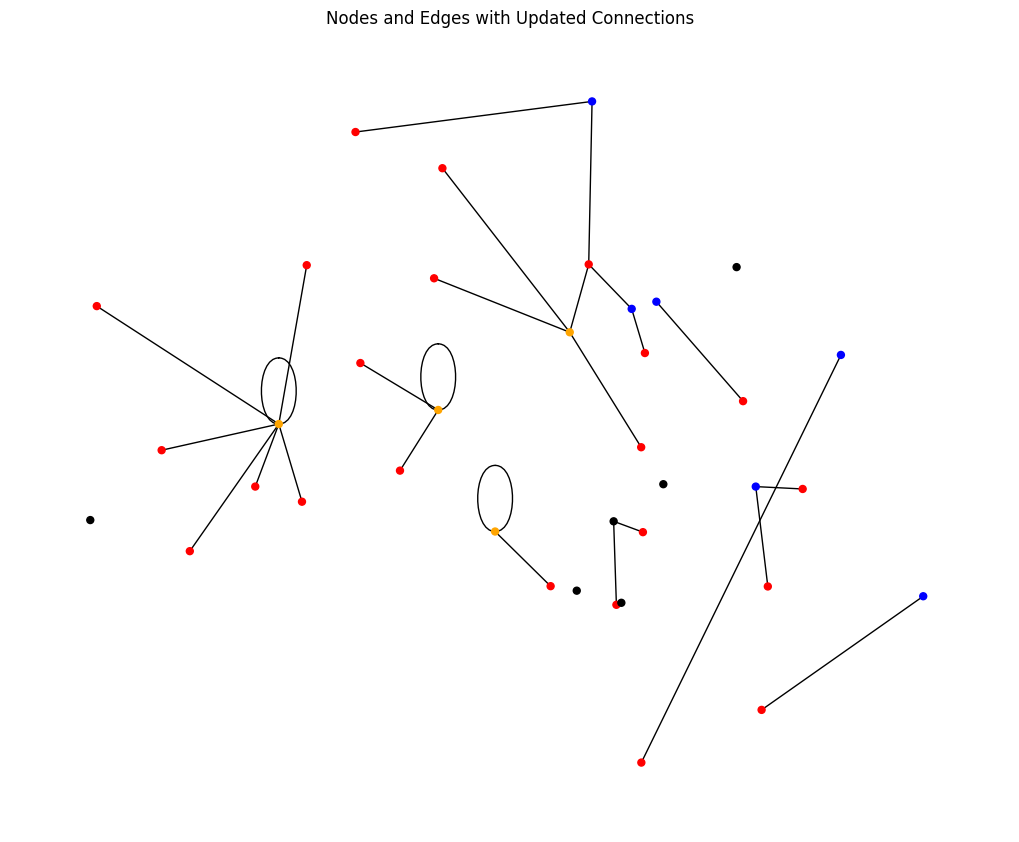

In [34]:
# Iterate over y to add edges based on y[i,j] == 1
for i in range(38):
    for j in range(25): # Ensure we don't duplicate edges or add self-loops
        if y[i,j,1].x == 1:
            G.add_edge(df.iloc[i]['Name'], df.iloc[j]['Name'])

# Draw the graph with updated edges
plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_color=updated_colors, with_labels=False, node_size=25)
plt.title('Nodes and Edges with Updated Connections')
plt.show()

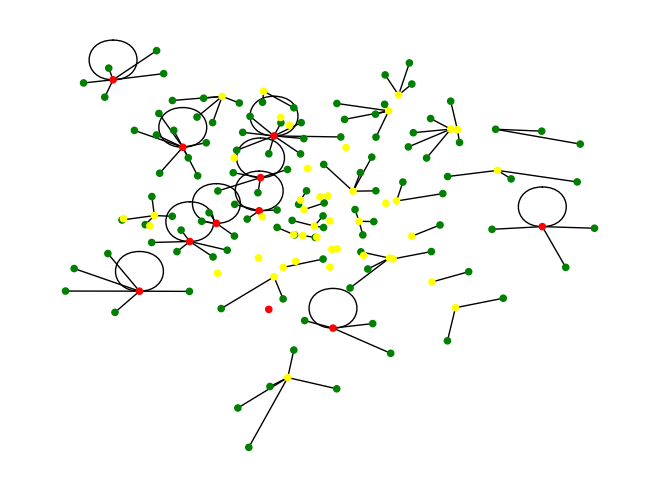

<Figure size 640x480 with 0 Axes>

In [141]:
for _, row in edge.iterrows():
    source = row['Source']
    target = row['Target']
    G.add_edge(source, target)

# Draw nodes
pos = nx.get_node_attributes(G, 'pos')
colors = nx.get_node_attributes(G, 'color').values()
nx.draw(G, pos, node_color=list(colors), with_labels=False, node_size=20)

# Show plot
plt.show()
plt.savefig('graph_image2.png')